# Practica 2 - Correlación y Preambulo

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import numpy.testing as npt
import pandas as pd

## 3.1 Parte 1: Correlación y Preámbulo

- i. Implemente la función de correlación. Presente la grafica de la función de autocorrelacion de una señal aleatoria

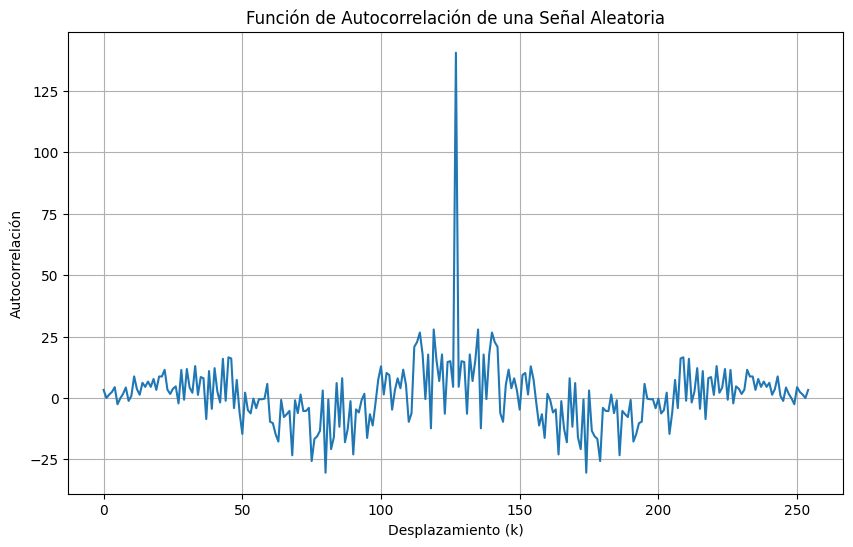

In [2]:
def correlacion(x, y):
    n = len(x)
    corr = np.correlate(x, y, mode='full')
    return corr

np.random.seed(0)
signal = np.random.randn(128)

autocorrelation = correlacion(signal, signal)

plt.figure(figsize=(10, 6))
plt.plot(autocorrelation)
plt.title("Función de Autocorrelación de una Señal Aleatoria")
plt.xlabel("Desplazamiento (k)")
plt.ylabel("Autocorrelación")
plt.grid(True)
plt.show()

## 3.2. Parte 2: Deteccion de preambulo usando correlacion

In [3]:
def detect_preamble(preamble, signal):
    ''' 
    Función para detectar el preambulo en una señal recibida.
    Parametros:
    - preamble: preambulo a detectar
    - signal: señal ingresada 
    Retorna:
    - preamble_start_idx: indice del preambulo
    '''
    threshold = 100  # Threshold para la deteccion del preambulo
    corr = np.correlate(signal, preamble, mode='valid')  # Calcular correlacion
    max_corr = np.max(np.abs(corr))  # Encontrar el valor maximo de la correlacion
    
    if max_corr > threshold:  # Verificar si el valor maximo supera el umbral
        preamble_start_idx = np.argmax(np.abs(corr))  # Obtener el indice del valor maximo
        return preamble_start_idx  # Retornar el indice del preambulo
    else:
        return None  # Retornar None si no se detecta el preambulo

In [4]:
# Probamos el algoritmo con una señal de ejemplo
preamble_length = 100
signal_length = 1000

# Generamos el preambulo de manera aleatoria y las señales de ejemplo
np.random.seed(0)
preamble = np.random.random(preamble_length) + 1j * np.random.random(preamble_length)
signalA = np.random.random(signal_length) + 1j * np.random.random(signal_length)
signalB = np.random.random(signal_length) + 1j * np.random.random(signal_length)

# Insertamos el preambulo en la señal B
preamble_start_idx = 123
signalB[preamble_start_idx:preamble_start_idx + preamble_length] += preamble

# Detectamos el preambulo en las señales A y B usando el algoritmo 
resultA = detect_preamble(preamble, signalA)
resultB = detect_preamble(preamble, signalB)

# Mostrar los resultados
resultA, resultB, preamble_start_idx


(None, 123, 123)

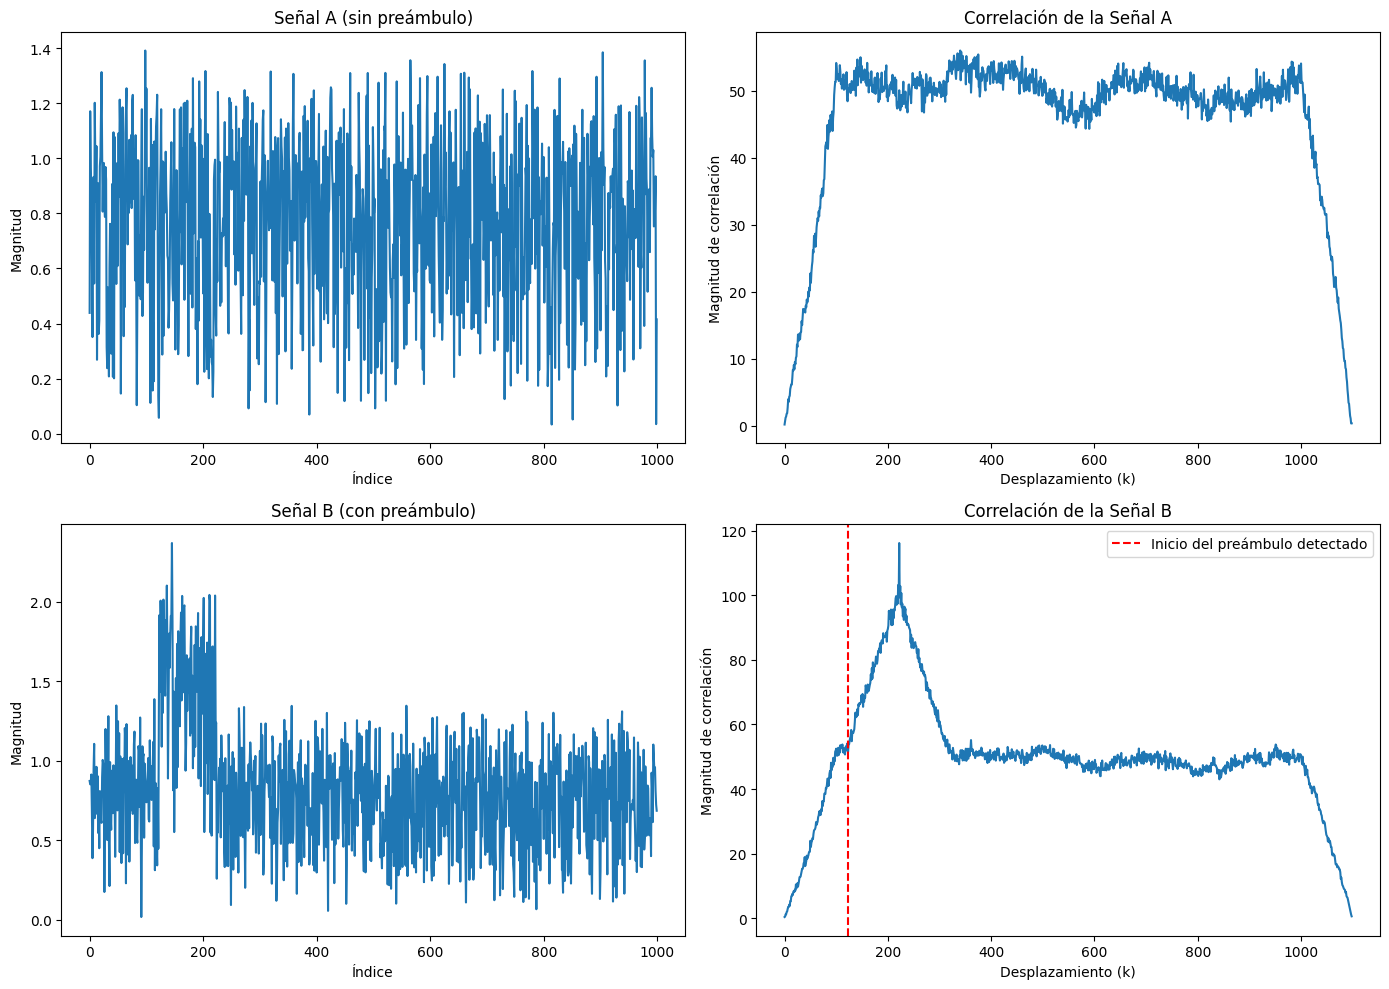

In [5]:
# Graficar la señal con y sin preámbulo, así como los resultados de la correlación

# Calculamos la correlación completa para ambas señales
correlationA = np.correlate(signalA, preamble, mode='full')
correlationB = np.correlate(signalB, preamble, mode='full')

# Graficar las señales y sus correlaciones
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

# Gráfica de la señal A (sin preámbulo) y su correlación
axs[0, 0].plot(np.abs(signalA))
axs[0, 0].set_title("Señal A (sin preámbulo)")
axs[0, 0].set_xlabel("Índice")
axs[0, 0].set_ylabel("Magnitud")

axs[0, 1].plot(np.abs(correlationA))
axs[0, 1].set_title("Correlación de la Señal A")
axs[0, 1].set_xlabel("Desplazamiento (k)")
axs[0, 1].set_ylabel("Magnitud de correlación")

# Gráfica de la señal B (con preámbulo) y su correlación
axs[1, 0].plot(np.abs(signalB))
axs[1, 0].set_title("Señal B (con preámbulo)")
axs[1, 0].set_xlabel("Índice")
axs[1, 0].set_ylabel("Magnitud")

axs[1, 1].plot(np.abs(correlationB))
axs[1, 1].set_title("Correlación de la Señal B")
axs[1, 1].set_xlabel("Desplazamiento (k)")
axs[1, 1].set_ylabel("Magnitud de correlación")
axs[1, 1].axvline(preamble_start_idx, color='r', linestyle='--', label="Inicio del preámbulo detectado")
axs[1, 1].legend()

plt.tight_layout()
plt.show()


## 3.3 Parte 3: Offset de frecuencia

In [6]:
def schmidl_cox_algorithm(signal, L, threshold=0.5):
    """
    Aplica el algoritmo de Schmidl-Cox para detectar el preámbulo.
    
    Parámetros:
    - signal: la señal recibida
    - L: longitud del segmento repetido
    - threshold: umbral para la detección
    
    Retorna:
    - El índice d* donde M(d) es máximo si supera el umbral, de lo contrario, None.
    """
    N = len(signal)
    
    # Inicializar P(d) y R(d)
    P = np.sum(np.conj(signal[:L]) * signal[L:2*L])
    R = 0.5 * np.sum(np.abs(signal[:2*L])**2)
    
    max_M = 0
    max_d = None
    
    M_values = []
    
    for d in range(N - 2*L):
        # Calcular M(d)
        M_d = (np.abs(P)**2) / (R**2)
        M_values.append(M_d)
        
        if M_d > max_M and M_d > threshold:
            max_M = M_d
            max_d = d
        
        # Iterar para P(d+1) y R(d+1)
        if d + 2*L < N:
            P = P + np.conj(signal[d+L]) * signal[d+2*L] - np.conj(signal[d]) * signal[d+L]
            R = R + 0.5 * (np.abs(signal[d+2*L])**2 - np.abs(signal[d])**2)
    # Graficar la señal completa
    plt.figure(figsize=(14, 6))
    plt.subplot(2, 1, 1)
    plt.plot(np.abs(signal), label="Señal")
    plt.title("Señal Recibida")
    plt.xlabel("Índice")
    plt.ylabel("Magnitud")
    plt.grid(True)
    
    # Graficar los valores de M(d)
    plt.subplot(2, 1, 2)
    plt.plot(M_values, label="M(d)")
    if max_d is not None:
        plt.axvline(max_d, color='r', linestyle='--', label="Índice del preámbulo detectado")
    plt.title("Valores de M(d) calculados por el algoritmo Schmidl-Cox")
    plt.xlabel("Índice (d)")
    plt.ylabel("M(d)")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    return max_d if max_M > threshold else None

In [7]:
def shift_frequency(signal, freq_offset):
    """
    Aplica un desplazamiento de frecuencia a una señal.
    
    Parámetros:
    - signal: la señal original
    - freq_offset: la cantidad de desplazamiento de frecuencia a aplicar
    
    Retorna:
    - La señal con el desplazamiento de frecuencia aplicado
    """
    n = np.arange(len(signal))
    return signal * np.exp(2j * np.pi * freq_offset * n)

def detect_preamble_with_freq_offset(signal, short_preamble_len):
    """
    Detecta el preámbulo utilizando el algoritmo Schmidl-Cox en presencia de un offset de frecuencia.
    
    Parámetros:
    - signal: la señal recibida con el preámbulo y ruido
    - short_preamble_len: la longitud del preámbulo corto
    
    Retorna:
    - El índice d* donde M(d) es máximo si supera el umbral, de lo contrario, None.
    """
    L = short_preamble_len  # Longitud del segmento repetido
    threshold = 0.5         # Umbral de Schmidl-Cox
    return schmidl_cox_algorithm(signal, L, threshold)  # Usamos el algoritmo implementado previamente


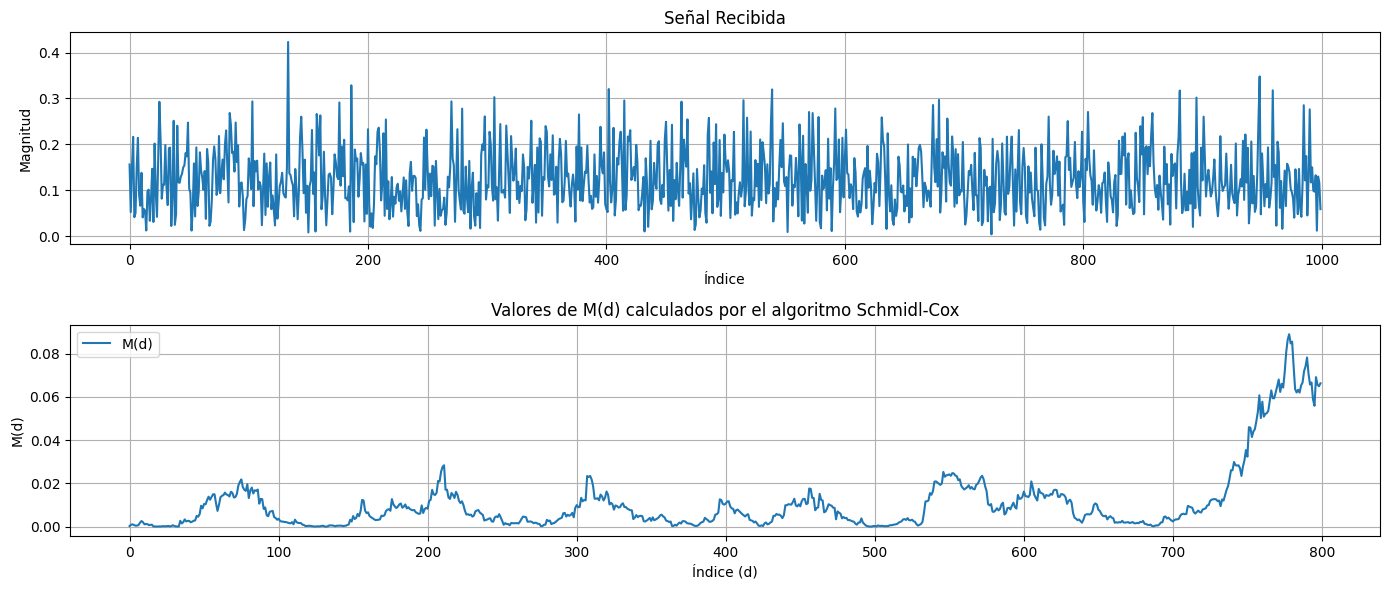

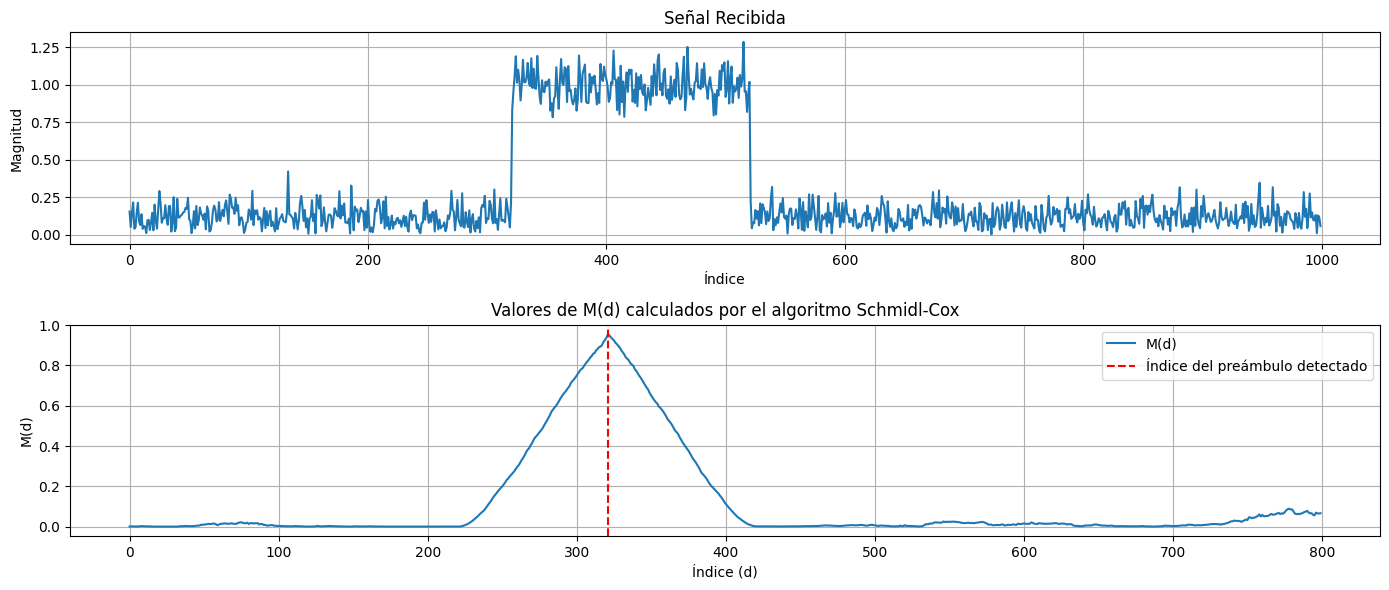

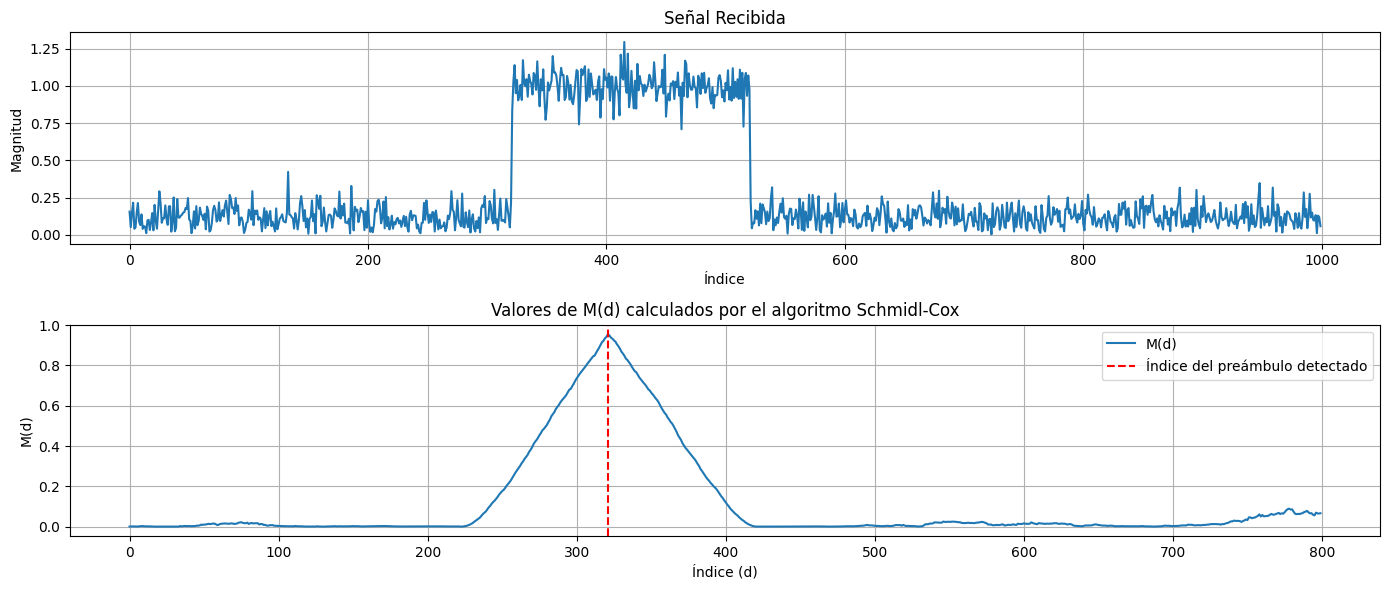

(None, 321, 321)

In [8]:
short_preamble_length = 100
signal_length = 1000

# Generación de las señales
np.random.seed(42)
short_preamble = np.exp(2j * np.pi * np.random.random(short_preamble_length))
preamble = np.tile(short_preamble, 2)
noise = np.random.normal(size=signal_length) + 1j * np.random.normal(size=signal_length)

signalA = 0.1 * noise
signalB = 0.1 * noise
signalC = 0.1 * noise

# Insertamos el preámbulo en signalB y signalC
preamble_start_idx = 321
signalB[preamble_start_idx:preamble_start_idx + len(preamble)] += preamble
signalC[preamble_start_idx:preamble_start_idx + len(preamble)] += shift_frequency(preamble, 0.1)

# Realizamos las pruebas con assert_equal
resultA = detect_preamble_with_freq_offset(signalA, short_preamble_length)
resultB = detect_preamble_with_freq_offset(signalB, short_preamble_length)
resultC = detect_preamble_with_freq_offset(signalC, short_preamble_length)

npt.assert_equal(resultA, None)
npt.assert_equal(resultB, 321)
npt.assert_equal(resultC, 321)

resultA, resultB, resultC
